In [18]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import sklearn
from sklearn.metrics import pairwise_distances_argmin_min

In [19]:
secrets_file = open("secrets.txt","r")

In [20]:
string = secrets_file.read()

In [21]:
string

'clientid:30ba48f11c4347f0aa53053cf58e318a\nclientsecret:74c98bc24a4c41fa9f0d89b6f86d216b'

In [22]:
string.split('\n')

['clientid:30ba48f11c4347f0aa53053cf58e318a',
 'clientsecret:74c98bc24a4c41fa9f0d89b6f86d216b']

In [23]:
secrets_dict={}
for line in string.split('\n'):
    if len(line) > 0:
        secrets_dict[line.split(':')[0]]=line.split(':')[1]

In [24]:
secrets_dict

{'clientid': '30ba48f11c4347f0aa53053cf58e318a',
 'clientsecret': '74c98bc24a4c41fa9f0d89b6f86d216b'}

In [25]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

#Initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['clientid'],
                                                           client_secret=secrets_dict['clientsecret']))

In [26]:
#We pick our playlists
fifties_playlist = "37i9dQZF1DWSV3Tk4GO2fq"
sixties_playlist = "3SbE5Sk5MWtNc0GRTU0X6d"
seventies_playlist = "37i9dQZF1DX1Hya1sRqqxI"
eighties_playlist = "37i9dQZF1DXb57FjYWz00c"
nineties_playlist = "37i9dQZF1DXbTxeAdrVG2l"
twenties_playlist = "37i9dQZF1DX4o1oenSJRJd"
twenty_tens_playlist = "37i9dQZF1DX5Ejj0EkURtP"
twenty_twenties_playlist = "4vSTV61efRmetmaoz95Vet"

In [27]:
#code to pass the 1050 limit for the tracks got from the api

def get_all_tracks(playlist):
    results = sp.user_playlist_tracks("spotify", playlist)
    tracks = results['items']
    for oset in range(1050,results['total'],1050):
        results = sp.user_playlist_tracks("spotify", playlist, offset=oset)
        tracks += results['items']
    return tracks

all_tracks_50s = get_all_tracks(fifties_playlist)
all_tracks_60s = get_all_tracks(sixties_playlist)
all_tracks_70s = get_all_tracks(seventies_playlist)
all_tracks_80s = get_all_tracks(eighties_playlist)
all_tracks_90s = get_all_tracks(nineties_playlist)
all_tracks_2000s = get_all_tracks(twenties_playlist)
all_tracks_2010s = get_all_tracks(twenty_tens_playlist)
all_tracks_2020s = get_all_tracks(twenty_twenties_playlist)

In [28]:
# Getting all the artists
def get_artists_from_playlist(playlist_id, tracks):
    tracks_from_playlist = tracks
    artists = []
    for track in tracks_from_playlist:
        artist_info = track['track']['artists'][0]
        artists.append(artist_info['name'])
    return artists


all_artists_50s = get_artists_from_playlist(fifties_playlist,all_tracks_50s)
all_artists_60s = get_artists_from_playlist(sixties_playlist,all_tracks_60s)
all_artists_70s = get_artists_from_playlist(seventies_playlist,all_tracks_70s)
all_artists_80s = get_artists_from_playlist(eighties_playlist,all_tracks_80s)
all_artists_90s = get_artists_from_playlist(nineties_playlist,all_tracks_90s)
all_artists_2000s = get_artists_from_playlist(twenties_playlist,all_tracks_2000s)
all_artists_2010s = get_artists_from_playlist(twenty_tens_playlist,all_tracks_2010s)
all_artists_2020s = get_artists_from_playlist(twenty_twenties_playlist,all_tracks_2020s)



In [29]:
#get song names & track ids
def get_song_names(tracks):
    song_actual_names = [track['track']['name'] for track in tracks]
    track_ids = [track['track']['id'] for track in tracks]
    return song_actual_names,track_ids

all_song_names_50s,id_track_50s = get_song_names(all_tracks_50s)
all_song_names_60s,id_track_60s = get_song_names(all_tracks_60s)
all_song_names_70s,id_track_70s = get_song_names(all_tracks_70s)
all_song_names_80s,id_track_80s = get_song_names(all_tracks_80s)
all_song_names_90s,id_track_90s = get_song_names(all_tracks_90s)
all_song_names_2000s,id_track_2000s = get_song_names(all_tracks_2000s)
all_song_names_2010s,id_track_2010s = get_song_names(all_tracks_2010s)
all_song_names_2020s,id_track_2020s = get_song_names(all_tracks_2020s)

In [30]:
#get all genres and popularity

def get_pop_and_genre(tracks):
    genre = []
    popularity = []
    for elem in tracks:
        artist01 = sp.artist(elem['track']["album"]["artists"][0]["external_urls"]["spotify"])
        genre.append(artist01["genres"][0] if artist01["genres"] else "genreless")
        popularity.append(artist01["popularity"])
    return genre,popularity

genre_50s,popularity_50s = get_pop_and_genre(all_tracks_50s)
genre_60s,popularity_60s = get_pop_and_genre(all_tracks_60s)
genre_70s,popularity_70s = get_pop_and_genre(all_tracks_70s)
genre_80s,popularity_80s = get_pop_and_genre(all_tracks_80s)
genre_90s,popularity_90s = get_pop_and_genre(all_tracks_90s)
genre_2000s,popularity_2000s = get_pop_and_genre(all_tracks_2000s)
genre_2010s,popularity_2010s = get_pop_and_genre(all_tracks_2010s)
genre_2020s,popularity_2020s = get_pop_and_genre(all_tracks_2020s)

In [31]:
#gathering main features and turning them into a dataframe
def main_features_to_df(track_ids):
    the_list = []
    for i in track_ids:
        the_list.append(sp.audio_features(i))
    converted = [i for elem in the_list for i in elem]
    df = pd.json_normalize(converted)
    return df

df_50s = main_features_to_df(id_track_50s)
df_60s = main_features_to_df(id_track_60s)
df_70s = main_features_to_df(id_track_70s)
df_80s = main_features_to_df(id_track_80s)
df_90s = main_features_to_df(id_track_90s)
df_2000s = main_features_to_df(id_track_2000s)
df_2010s = main_features_to_df(id_track_2010s)
df_2020s = main_features_to_df(id_track_2020s)

In [32]:
# adding previous single gathered features to the current df
def add_features_to_df(song_actual_names,artist_list,genre,popularity,features_df):
    
    df_song_name = pd.DataFrame(song_actual_names, columns = ["song_name"])
    df_artists = pd.DataFrame(artist_list,columns = ["artists"])
    df_genre = pd.DataFrame(genre,columns = ["genre"])
    df_popularity = pd.DataFrame(popularity,columns = ["popularity"])
    final_boss_df = pd.concat([features_df, df_song_name,df_artists,df_genre,df_popularity], axis=1)
    
    return final_boss_df

final_df_50s = add_features_to_df(all_song_names_50s,all_artists_50s,genre_50s,popularity_50s,df_50s)
final_df_60s = add_features_to_df(all_song_names_60s,all_artists_60s,genre_60s,popularity_60s,df_60s)
final_df_70s = add_features_to_df(all_song_names_70s,all_artists_70s,genre_70s,popularity_70s,df_70s)
final_df_80s = add_features_to_df(all_song_names_80s,all_artists_80s,genre_80s,popularity_80s,df_80s)
final_df_90s = add_features_to_df(all_song_names_90s,all_artists_90s,genre_90s,popularity_90s,df_90s)
final_df_2000s = add_features_to_df(all_song_names_2000s,all_artists_2000s,genre_2000s,popularity_2000s,df_2000s)
final_df_2010s = add_features_to_df(all_song_names_2010s,all_artists_2010s,genre_2010s,popularity_2010s,df_2010s)
final_df_2020s = add_features_to_df(all_song_names_2020s,all_artists_2020s,genre_2020s,popularity_2020s,df_2020s)

In [33]:
#Treating the dataframe:
scaler = StandardScaler()
def scaling_df(current_df):
    df_to_scale = current_df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','popularity']]
    scaled_df02 = scaler.fit_transform(df_to_scale)
    scaled_df01 = pd.DataFrame(scaled_df02)
    scaled_df = scaled_df01.copy()
    scaled_df.columns = df_to_scale.columns
    scaled_df["song_name"] = current_df["song_name"]
    scaled_df["artists"] = current_df["artists"]
    scaled_df["genre"] = current_df["genre"]
    scaled_df
    return scaled_df01,scaled_df

df_to_scale_50s,scaled_df_50s = scaling_df(final_df_50s)
df_to_scale_60s,scaled_df_60s = scaling_df(final_df_60s)
df_to_scale_70s,scaled_df_70s = scaling_df(final_df_70s)
df_to_scale_80s,scaled_df_80s = scaling_df(final_df_80s)
df_to_scale_90s,scaled_df_90s = scaling_df(final_df_90s)
df_to_scale_2000s,scaled_df_2000s = scaling_df(final_df_2000s)
df_to_scale_2010s,scaled_df_2010s = scaling_df(final_df_2010s)
df_to_scale_2020s,scaled_df_2020s = scaling_df(final_df_2020s)

In [34]:
scaled_complete_frames = [scaled_df_50s,scaled_df_60s,scaled_df_70s,scaled_df_80s,scaled_df_90s,scaled_df_2000s,scaled_df_2010s,scaled_df_2020s]

all_frames = pd.concat(scaled_complete_frames)
all_frames.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,song_name,artists,genre
0,0.602031,0.052400,1.490470,-0.238877,0.51558,1.505372,0.825760,-0.181090,-0.386575,1.211074,-1.363127,1.701652,All Shook Up,Elvis Presley,rock-and-roll
1,0.310364,-0.821901,-1.176375,-0.338655,0.51558,-0.507625,-1.174755,-0.181065,-0.613190,-0.149747,0.159780,1.878080,I've Got You Under My Skin - Remastered 1998,Frank Sinatra,adult standards
2,-2.546477,-0.632008,-0.583743,-0.015596,0.51558,-0.676105,1.007625,-0.181134,-0.208958,-1.303240,1.425887,-0.062632,Smoke Gets In Your Eyes,The Platters,adult standards
3,-0.026175,0.895053,-0.287427,1.251583,0.51558,-0.271317,0.485346,-0.181155,-0.276330,0.615479,-0.953866,0.466653,"What'd I Say, Pt. 1 & 2",Ray Charles,adult standards
4,-0.616988,-1.067180,-0.880059,-1.552620,0.51558,-0.284445,-0.465947,-0.181155,-0.527444,-0.850890,-0.749206,0.995938,Dream A Little Dream Of Me,Louis Armstrong,adult standards


In [35]:
scaled_numerical_frames = [df_to_scale_50s,df_to_scale_60s,df_to_scale_70s,df_to_scale_80s,df_to_scale_90s,df_to_scale_2000s,df_to_scale_2010s,df_to_scale_2020s]
Numerical_all_frames = pd.concat(scaled_numerical_frames)

In [36]:
Numerical_all_frames

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.602031,0.052400,1.490470,-0.238877,0.515580,1.505372,0.825760,-0.181090,-0.386575,1.211074,-1.363127,1.701652
1,0.310364,-0.821901,-1.176375,-0.338655,0.515580,-0.507625,-1.174755,-0.181065,-0.613190,-0.149747,0.159780,1.878080
2,-2.546477,-0.632008,-0.583743,-0.015596,0.515580,-0.676105,1.007625,-0.181134,-0.208958,-1.303240,1.425887,-0.062632
3,-0.026175,0.895053,-0.287427,1.251583,0.515580,-0.271317,0.485346,-0.181155,-0.276330,0.615479,-0.953866,0.466653
4,-0.616988,-1.067180,-0.880059,-1.552620,0.515580,-0.284445,-0.465947,-0.181155,-0.527444,-0.850890,-0.749206,0.995938
...,...,...,...,...,...,...,...,...,...,...,...,...
95,-2.352959,-0.054250,0.521060,-0.042092,-1.362770,-0.385756,-0.099868,-0.160575,0.201164,-1.210318,1.910956,-2.040102
96,0.069340,-0.672448,1.047383,-0.075190,-1.362770,-0.070180,0.434831,-0.160575,-0.462378,-0.070073,0.743495,0.510026
97,0.593463,-0.647215,-1.321071,-1.158782,0.733799,0.413557,-0.051984,-0.158214,-0.538940,0.051785,0.331545,1.410071
98,0.423477,1.421855,-1.057909,0.933094,-1.362770,1.352640,-1.001113,-0.160575,-1.035746,0.156235,-1.254693,-0.690035


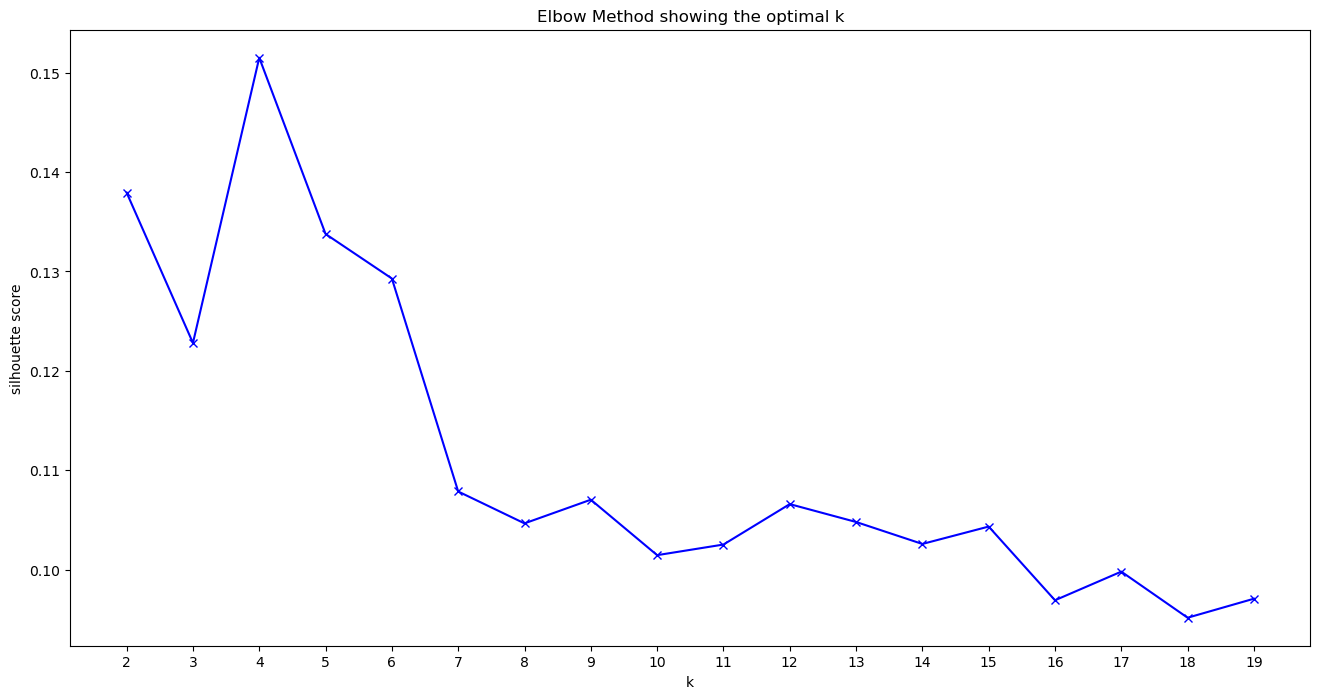

In [37]:
#applying inertia to see how many clusters is a good number to apply

K = range(2, 20)

silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(Numerical_all_frames)
    silhouette.append(silhouette_score(Numerical_all_frames, kmeans.predict(Numerical_all_frames)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')
plt.show()

In [38]:
#applying the clustering

kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(Numerical_all_frames)

KMeans(n_clusters=7, random_state=42)

In [39]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(Numerical_all_frames)
clusters

array([6, 5, 1, 4, 5, 4, 6, 4, 0, 5, 0, 1, 0, 5, 5, 5, 6, 1, 5, 5, 5, 4,
       1, 1, 5, 4, 0, 4, 5, 5, 2, 6, 6, 5, 1, 4, 1, 0, 6, 0, 2, 5, 1, 4,
       0, 4, 4, 4, 5, 5, 4, 4, 4, 5, 5, 5, 0, 0, 1, 6, 5, 4, 0, 6, 4, 4,
       4, 4, 2, 5, 4, 2, 5, 4, 2, 0, 2, 1, 1, 1, 0, 0, 5, 5, 2, 6, 2, 3,
       5, 4, 3, 1, 4, 4, 5, 1, 0, 0, 4, 5, 0, 2, 2, 5, 1, 6, 4, 0, 4, 5,
       0, 6, 0, 2, 0, 6, 1, 1, 2, 5, 4, 4, 4, 4, 1, 4, 4, 0, 2, 4, 1, 4,
       5, 5, 2, 4, 2, 4, 1, 6, 4, 4, 4, 2, 5, 5, 5, 0, 1, 0, 2, 0, 0, 5,
       5, 3, 5, 5, 4, 0, 1, 5, 4, 1, 0, 5, 0, 1, 4, 4, 1, 4, 6, 5, 0, 0,
       5, 0, 3, 4, 1, 4, 4, 5, 1, 6, 5, 4, 2, 0, 4, 0, 5, 5, 5, 0, 0, 2,
       0, 1, 5, 0, 5, 5, 5, 4, 5, 0, 4, 4, 4, 5, 5, 0, 2, 5, 4, 0, 1, 5,
       5, 5, 5, 4, 6, 2, 4, 5, 0, 4, 5, 5, 6, 5, 4, 5, 6, 5, 4, 4, 4, 3,
       1, 1, 2, 4, 0, 0, 5, 0, 4, 5, 5, 4, 5, 0, 4, 2, 0, 0, 5, 2, 2, 4,
       0, 2, 4, 3, 4, 5, 1, 1, 1, 0, 5, 5, 3, 0, 5, 5, 4, 0, 1, 4, 5, 5,
       0, 0, 3, 5, 6, 2, 0, 4, 3, 6, 5, 0, 0, 0, 0,

In [40]:
#assigning the clusters to the main final df
all_frames["clusters"] = clusters

In [41]:
# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0    166
1     87
2     81
3     21
4    191
5    191
6     62
dtype: int64

In [42]:
all_frames.groupby(['clusters','genre'], as_index=False).count().sort_values(['clusters', 'key'], ascending=[True, False])[['genre', 'clusters', 'key']].reset_index(drop=True).groupby(["clusters"]).head(3)


,genre,clusters,key
0,dance pop,0,24
1,adult standards,0,13
2,pop,0,11
64,adult standards,1,22
65,pop,1,10
66,art pop,1,7
95,dance pop,2,11
96,adult standards,2,8
97,album rock,2,6
136,adult standards,3,2


In [43]:
all_frames = all_frames.reset_index(drop=True)

In [44]:
all_frames

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,song_name,artists,genre,clusters
0,0.602031,0.052400,1.490470,-0.238877,0.515580,1.505372,0.825760,-0.181090,-0.386575,1.211074,-1.363127,1.701652,All Shook Up,Elvis Presley,rock-and-roll,6
1,0.310364,-0.821901,-1.176375,-0.338655,0.515580,-0.507625,-1.174755,-0.181065,-0.613190,-0.149747,0.159780,1.878080,I've Got You Under My Skin - Remastered 1998,Frank Sinatra,adult standards,5
2,-2.546477,-0.632008,-0.583743,-0.015596,0.515580,-0.676105,1.007625,-0.181134,-0.208958,-1.303240,1.425887,-0.062632,Smoke Gets In Your Eyes,The Platters,adult standards,1
3,-0.026175,0.895053,-0.287427,1.251583,0.515580,-0.271317,0.485346,-0.181155,-0.276330,0.615479,-0.953866,0.466653,"What'd I Say, Pt. 1 & 2",Ray Charles,adult standards,4
4,-0.616988,-1.067180,-0.880059,-1.552620,0.515580,-0.284445,-0.465947,-0.181155,-0.527444,-0.850890,-0.749206,0.995938,Dream A Little Dream Of Me,Louis Armstrong,adult standards,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,-2.352959,-0.054250,0.521060,-0.042092,-1.362770,-0.385756,-0.099868,-0.160575,0.201164,-1.210318,1.910956,-2.040102,Boyfriend,Dove Cameron,pop,0
795,0.069340,-0.672448,1.047383,-0.075190,-1.362770,-0.070180,0.434831,-0.160575,-0.462378,-0.070073,0.743495,0.510026,Yummy,Justin Bieber,canadian pop,0
796,0.593463,-0.647215,-1.321071,-1.158782,0.733799,0.413557,-0.051984,-0.158214,-0.538940,0.051785,0.331545,1.410071,Laugh Now Cry Later (feat. Lil Durk),Drake,canadian hip hop,5
797,0.423477,1.421855,-1.057909,0.933094,-1.362770,1.352640,-1.001113,-0.160575,-1.035746,0.156235,-1.254693,-0.690035,THATS WHAT I WANT,Lil Nas X,lgbtq+ hip hop,0
